<a href="https://colab.research.google.com/github/amirnugroho/UAS_DeepLearning/blob/main/3_Feature_Importance_(NASA_FIRMS_MODIS)_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Muat dataset dari path yang Anda unggah
file_path = '/content/modis_2024_Indonesia.csv'
data = pd.read_csv(file_path)

# Summary Statistics (tetap sama)
print("Dataset Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Missing Values:", data.isnull().sum().to_dict())
print(data.describe())

Dataset Shape: (23542, 15)
Columns: ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type']
Missing Values: {'latitude': 0, 'longitude': 0, 'brightness': 0, 'scan': 0, 'track': 0, 'acq_date': 0, 'acq_time': 0, 'satellite': 0, 'instrument': 0, 'confidence': 0, 'version': 0, 'bright_t31': 0, 'frp': 0, 'daynight': 0, 'type': 0}
           latitude     longitude   brightness          scan         track  \
count  23542.000000  23542.000000  23542.00000  23542.000000  23542.000000   
mean      -2.903840    114.158531    319.23814      1.416626      1.148976   
std        3.740767      9.047035     11.43915      0.639413      0.205317   
min      -10.836400     95.410400    300.00000      1.000000      1.000000   
25%       -6.932275    108.387075    312.60000      1.000000      1.000000   
50%       -2.117950    112.807750    316.90000      1.100000      1.100000   
75%      

RMSE: 5.474932243113224


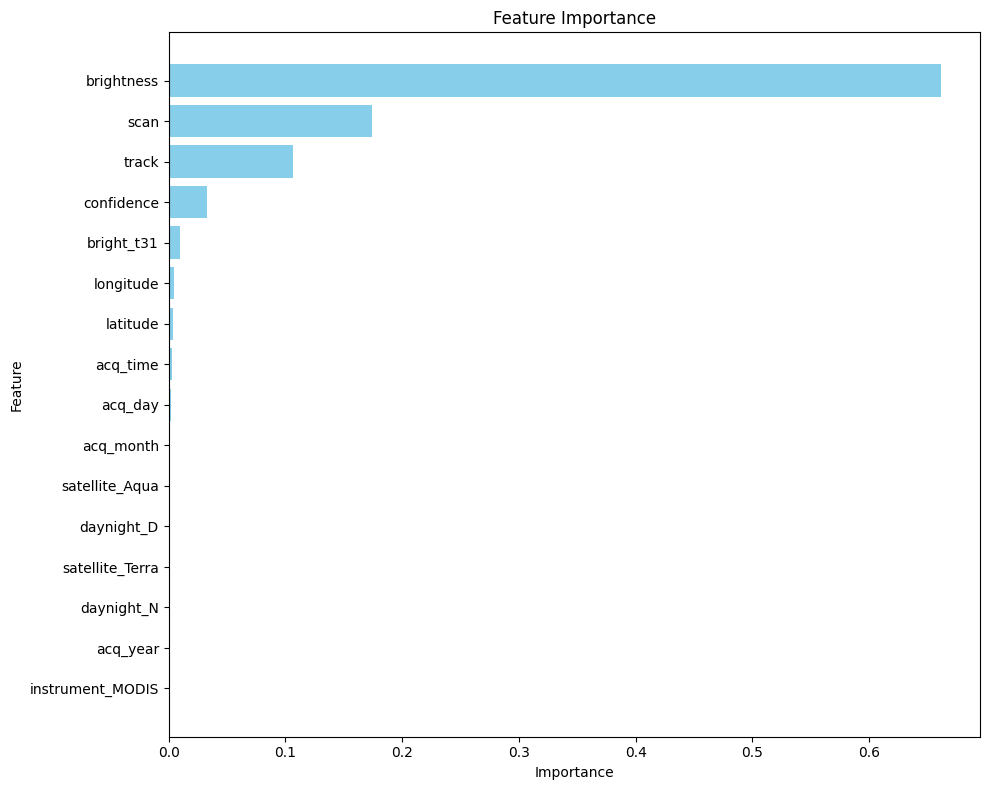

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# After Loading the data (replace with actual file path)
data = pd.read_csv('modis_2024_Indonesia.csv')

# 1. Feature Engineering: Extract date features
data['acq_date'] = pd.to_datetime(data['acq_date'])
data['acq_day'] = data['acq_date'].dt.day
data['acq_month'] = data['acq_date'].dt.month
data['acq_year'] = data['acq_date'].dt.year

# 2. Define features and target
numerical_features = ['latitude', 'longitude', 'brightness', 'scan', 'track',
                      'acq_time', 'confidence', 'bright_t31', 'acq_day', 'acq_month', 'acq_year']
categorical_features = ['satellite', 'instrument', 'daynight']

X = data[numerical_features + categorical_features]
y = data['frp']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

# 5. Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 6. Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 7. Train the pipeline
model.fit(X_train, y_train)

# 8. Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# 9. Feature Importance
rf_model = model.named_steps['regressor']
importances = rf_model.feature_importances_
feature_names = (
    numerical_features +
    list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))
)

# Plot feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
